# Cash Transfer Experiement
We use the cash transfer dataset (Angelucci and Giorgi, 2009) to illustrate the statistical bound in our paper. The data comes from a study of the impact of Progresa, a social program in Mexico that gives cash gifts to low income households. Although, the effects on the population receiving the cash transfers is important, Angelucci and Giorgi argue that we must also analyze the impact on the remaining members of the village that are not eligible in order to understandardized the full impact of the program.  However, due to concerns that the non-poor households might have a large influence, the authors decided to limit the range of consumption outcomes for these households (less than 10,000). This results in robustness in the analysis for the poor household but sensitive results for the non-poor households. For our analysis we will  only use data from time period 8. After removing all entries with no response variable (household consumption), we used the remaining $n = 53552$ datapoints. 

In [25]:
# Download Data
from sklearn import preprocessing
import pandas as pd
import numpy as np
from data_cleaning import cash_transfer_data

standardized_data = cash_transfer_data(
    "../data/cash_transfer_data/table1.dta")[0]


/home/jrfish/nlp/AISTAT_2022_InfuenceFunction/experiments/economic_data/data_cleaning.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)


# Empirical Influence Function for Ridge Regression
We will use the following closed form solution for the empirical influence function provided by Cook and Weisberg (1982).

$I_n(z)= -H_n(\theta_n)^{-1}(\psi(z,\theta_n))$

where $z=(x, y)$.

We define the following:

$H_n(\theta_n) =  \frac1n \sum_{i=1}^n x_ix_i^T + \lambda_1 I$ 

$\psi(z,\theta_n) = \nabla \ell(z,\theta_n) = -(y-x^T\theta_n)x + \sum \lambda_1*\theta_n$

$\theta_n$ is calculated using ridge regression

In [26]:
# Empirical Influence Function 
from scipy.linalg import block_diag
from numpy.linalg import inv
import numpy as np

# Finding theta values using Ridge
from sklearn import linear_model
def ridge(x, y, lambda1):
    hess = np.matmul(x.T, x) + lambda1 * np.eye(x.shape[1])  # (d, d)
    grad = np.matmul(x.T, y) # (d,)
    return np.linalg.solve(hess, grad)   # hess^{-1} grad

def if_linear_emp(x, y, x_con, y_con, lambda1, n):
    theta_n = ridge(x, y, lambda1)
    hess =  np.matmul(x.T, x) / n + lambda1 * np.eye(x.shape[1])
    grad = (np.dot(x_con, theta_n) - y_con).item() * x_con + np.sum(lambda1*theta_n)
    return -np.linalg.solve(hess, np.transpose(grad)) , hess

## Run Experiements
We now calculate the difference between the empirical influence and population influence of $100$ training datapoint using different sub-samples of the dataset ($n = 49, 201, 814, 3287, 13268$). We consider the influence calcuated using the whole dataset ($n=53552$) as the poulation. We use $\lambda_1 = 0.01$. 


In [27]:
# Runs n_sim number of simulations computing population and empirical IF on one contaminated point
def if_diff_n(data,time,n_sim, lambda1):
    if_ls_p ={}
    if_ls_np ={}
    if_ls_tot ={}
    H_pop = []
    # Filter data to time period
    data = data[data['t'] == time]
    n_ls = list(np.logspace(np.log10(50),np.log10(len(data)),6).astype(int))
    # Generate random sample of contamination data points
    influence_dfs = data.sample(n_sim,random_state=2)
    for n in n_ls:
        # Generate random training sample of size n
        sample_df = data.sample(n,random_state=1)
        infl_p = []
        infl_np = []
        infl_tot = []
        for i in range(n_sim):
            i_df = influence_dfs[i:i+1]
            x = sample_df[['treatp','treatnp','hhhsex_bi','hectareas','vhhnum','hhhage_cl', 'hhhspouse_cl']]
            y = sample_df['Cind']
            x_con = i_df[['treatp','treatnp','hhhsex_bi','hectareas','vhhnum','hhhage_cl', 'hhhspouse_cl']]
            y_con = i_df['Cind']
            if_all, H = if_linear_emp(x,y,x_con,y_con,lambda1, n)
            infl_p.append(if_all[0])
            infl_np.append(if_all[1])
            infl_tot.append(if_all)
            if i == 0:
                H_pop.append(H)
        if_ls_p[n] = infl_p
        if_ls_np[n] = infl_np
        if_ls_tot[n] = infl_tot

    return(if_ls_p, if_ls_np,if_ls_tot, n_ls, H_pop)

In [28]:
# Run Simulation
time = 8
n_sim = 100
lambda1=.01
results_p, results_np,results_tot, n_ls, H_pop = if_diff_n(standardized_data,time, n_sim, lambda1)

# Extract Results
results_mean_p = []
results_sd_p = []
results_mean_np = []
results_sd_np = []
bound_val = []
mean_diff_abs_total = []
sd_diff_abs_total = []
for i, n in enumerate(n_ls[0:len(n_ls)-1]):
    results_mean_p.append((pd.DataFrame(results_p)[n] - pd.DataFrame(results_p)[n_ls[5]]).abs().mean())
    results_sd_p.append(1.96*(pd.DataFrame(results_p)[n] - pd.DataFrame(results_p)[n_ls[5]]).abs().std())
    results_mean_np.append((pd.DataFrame(results_np)[n] - pd.DataFrame(results_np)[n_ls[5]]).abs().mean())
    results_sd_np.append(1.96*(pd.DataFrame(results_np)[n] - pd.DataFrame(results_np)[n_ls[5]]).abs().std())
    for j in range(len(results_tot)):
        diff_abs_total = np.abs(pd.DataFrame(results_tot)[n][j] - pd.DataFrame(results_tot)[n_ls[5]][j])
        bound_val.append(np.dot(np.matmul(H_pop[i],diff_abs_total),np.transpose(diff_abs_total)))
    mean_diff_abs_total.append(np.mean(bound_val))
    sd_diff_abs_total.append(np.std(bound_val))

# standardization
def standardized(data):
    return([d/data[0] for d in data])

# Clean data
mean_diff_abs_total = standardized(mean_diff_abs_total)
sd_diff_abs_total = standardized(sd_diff_abs_total)

/home/jrfish/miniconda3/envs/mend/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  if __name__ == "__main__":
/home/jrfish/miniconda3/envs/mend/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert

## Calculate Statistical Bound (Theorem 1)
We calculate the bound from Theorem 1 without coefficients using the following equations. 

$\|I_n(z) - I(z)\|_{H_\star}^2 \leq \frac{p_\star^2}{\mu_\star n} log(\frac p\delta)^3$

where, $p_\star = \text{Tr}\bigg [H_\star^{-1/2}G_\star H_\star^{-1/2} \bigg] = \text{Tr}\bigg [H_\star^{-1}G_\star\bigg ]$


In [29]:
# Calculate Statistical Bound (Theorem 1)
from scipy.linalg import sqrtm
import numpy as np
def stat_bound(p_star, mu_star,n,delta,p):
    return((p_star**2)/((mu_star)*pd.DataFrame(n))*np.log(p/delta)**3)

def p_star_func(H,x_con, y_con, theta_n):
    H_inverse = np.linalg.inv(H) 
    # Find G_\star, gradient of a single point 
    grad = (np.dot(x_con, theta_n)- y_con).item()* x_con - np.sum(lambda1*theta_n)
    G_star = np.average(np.dot(grad,np.transpose(grad)))# 1
    return(np.trace(H_inverse*G_star))

# Use only data from time period 8 (same as training data used in experiment)
t=8
data = standardized_data[standardized_data['t'] == time]
x_pop = data[['treatp','treatnp','hhhsex_bi','hectareas','vhhnum','hhhage_cl', 'hhhspouse_cl']]
y_pop = data['Cind']

# Sample a training data point
tr_df = data.sample(1,random_state=2)
x_con = tr_df[['treatp','treatnp','hhhsex_bi','hectareas','vhhnum','hhhage_cl', 'hhhspouse_cl']]
y_con = tr_df['Cind']

# Calculate bound
n = len(y_pop)
lambda1 = .01
theta_n = ridge(x_pop,y_pop, lambda1)
H_pop = np.matmul(x_pop.T, x_pop) / n + lambda1 * np.eye(x_pop.shape[1])
delta = .05
p_star = p_star_func(H_pop,x_con,y_con, theta_n)
mu_star = np.min(np.linalg.eig(H_pop)[0])
stat_bound_ls=stat_bound(p_star,mu_star,n_ls,delta,9)


/home/jrfish/miniconda3/envs/mend/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  if __name__ == "__main__":
/home/jrfish/miniconda3/envs/mend/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert

## Graph Results

In [30]:
# Graphing Parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['lines.markersize'] = 12
shape = ["o","X", "s","^", "P"]
line = ["solid", "dotted", "dashed", "dashdot","loosely dotted"]
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

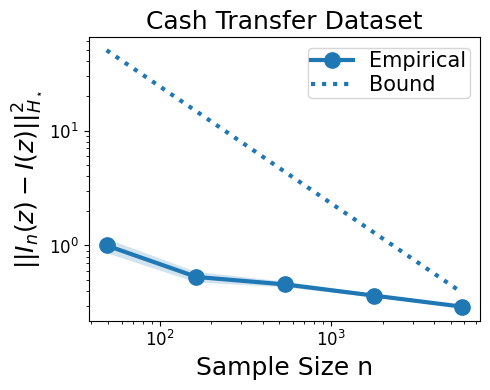

In [31]:
n_ls = [49, 164, 540, 1775, 5835]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax.plot(n_ls, mean_diff_abs_total, color = COLORS[0],marker = shape[0], markersize = 11, label = "Empirical")
ax.plot(n_ls,pd.DataFrame(50*stat_bound_ls[0]/np.max(stat_bound_ls[0]))[0:5], color = COLORS[0], linestyle = line[1], label = "Bound")
ax.fill_between(n_ls, [np.abs(m-sd/np.sqrt(n)).item() for m,sd,n in zip(mean_diff_abs_total, sd_diff_abs_total, n_ls)], [np.abs(m+sd/np.sqrt(n)).item() for m,sd,n in zip(mean_diff_abs_total, sd_diff_abs_total,n_ls)], alpha=0.2)
ax.set_ylabel(r'$\|\| I_{n}(z) - I(z) \|\|_{H_\star}^2$')
ax.set_xlabel("Sample Size n")
ax.set_title('Cash Transfer Dataset')
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc='upper right', borderpad=.15, labelspacing=.2)


plt.tight_layout()
plt.savefig("../../graphs/real_data_cash_bound.pdf")
plt.savefig("../../graphs/real_data_cash_bound.png")